In [7]:
# Core

import os, json, warnings, random, subprocess, textwrap

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt



# Data & preprocessing

import yfinance as yf

import pandas_market_calendars as mcal

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



# Deep learning

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import optimizers, losses, metrics, backend as K



warnings.filterwarnings("ignore")



# Repro seeds (best-effort)

SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)

os.environ["TF_DETERMINISTIC_OPS"] = "1"

random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)



# ---- User-editable knobs ----

LOOKBACK       = 90          # changed from 60 to 90 to match model input

TRIM_YEARS     = 10          # keep recent years only

CALENDAR       = "XNYS"      # NYSE calendar

MAX_FUTURE_DAYS= 252

BASE_DIR       = "models/base_aapl"   # <-- your exported AAPL model lives here



# Fine-tune knobs (used only when ticker != AAPL)

FT_EPOCHS      = 60

FT_BATCH_SIZE  = 64

FT_LR          = 1e-4        # gentle LR



print("TensorFlow:", tf.__version__)

print("GPU(s):", tf.config.list_physical_devices('GPU'))



TensorFlow: 2.20.0
GPU(s): []


In [8]:
def _last_completed_utc_day():
    return (pd.Timestamp.utcnow().normalize() - pd.Timedelta(days=1))

def _utc_midnight_naive(ts):
    ts = pd.Timestamp(ts)
    if ts.tzinfo is None or ts.tz is None:
        ts = ts.tz_localize("UTC")
    else:
        ts = ts.tz_convert("UTC")
    return ts.normalize().tz_localize(None)

def _resolve_dates(start=None, end=None):
    s = pd.Timestamp(start) if start else pd.Timestamp("2000-01-01")
    e = pd.Timestamp(end)   if end   else _last_completed_utc_day()
    return _utc_midnight_naive(s), _utc_midnight_naive(e)

def _flatten_columns(cols, ticker_expected=None):
    if isinstance(cols, pd.MultiIndex):
        if cols.nlevels == 2:
            second = {t for (_, t) in cols}
            if len(second) == 1 and (ticker_expected is None or list(second)[0] == ticker_expected):
                flat = [str(f) for (f, _) in cols]
            else:
                flat = ["_".join([str(x) for x in tup if x is not None]) for tup in cols]
        else:
            flat = ["_".join([str(x) for x in tup if x is not None]) for tup in cols]
    else:
        flat = [str(c) for c in cols]
    return [c.strip().title().replace(" ", "_") for c in flat]

def fetch_ohlc_yf(ticker, start_dt, end_dt, auto_adjust=True):
    start_s, end_s = str(start_dt.date()), str(end_dt.date())
    df = yf.download(
        tickers=ticker, start=start_s, end=end_s,
        auto_adjust=auto_adjust, progress=False, threads=True, group_by="column"
    )
    if df is None or df.empty:
        raise ValueError(f"No data for {ticker} between {start_s} and {end_s}")
    df.index = pd.to_datetime(df.index, utc=False)
    if getattr(df.index, "tz", None) is not None:
        df.index = df.index.tz_localize(None)
    df = df.sort_index().loc[~df.index.duplicated(keep="first")]
    df.columns = _flatten_columns(df.columns, ticker_expected=ticker.upper())
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(how="all")
    # align to trading calendar
    cal = mcal.get_calendar(CALENDAR)
    sched = cal.schedule(start_date=start_s, end_date=end_s)
    idx = sched.index
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_localize(None)
    idx = pd.DatetimeIndex(idx)
    df = df.loc[df.index.intersection(idx)]
    if "Close" not in df.columns or df.empty:
        raise ValueError("Bad dataframe after alignment.")
    return df

def create_sequences_stdret(data_scaled: pd.DataFrame, lookback: int, last_close_aligned: pd.Series):
    """Build (X,y,prev_close) from standardized log-returns."""
    X, y, lc = [], [], []
    vals = data_scaled["LogRet"].values
    lcs  = last_close_aligned.reindex(data_scaled.index).values
    for i in range(lookback, len(vals)):
        X.append(vals[i-lookback:i].reshape(lookback,1))
        y.append(vals[i])
        lc.append(lcs[i])
    return np.asarray(X, np.float32), np.asarray(y, np.float32), np.asarray(lc, np.float32)

def future_trading_days(last_date: pd.Timestamp, n: int) -> pd.DatetimeIndex:
    cal = mcal.get_calendar(CALENDAR)
    start_d = (last_date + pd.Timedelta(days=1)).date()
    end_d   = (last_date + pd.DateOffset(days=max(10, n*3))).date()
    sched = cal.schedule(start_date=start_d, end_date=end_d)
    idx = sched.index
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_localize(None)
    idx = pd.DatetimeIndex(idx)[:n]
    if len(idx) < n: raise ValueError("Not enough future trading days.")
    return idx

def recursive_forecast(model, scaler, seed_window, last_close, n_days, last_history_date):
    """Predict standardized returns recursively → inverse-scale → price."""
    preds_std, preds_log, preds_close = [], [], []
    cur = seed_window.copy()
    prev = last_close
    for _ in range(n_days):
        y_std = float(model.predict(cur.reshape(1, LOOKBACK, 1), verbose=0).ravel()[0])
        y_log = float(scaler.inverse_transform([[y_std]])[0, 0])
        nxt   = prev * np.exp(y_log)
        preds_std.append(y_std); preds_log.append(y_log); preds_close.append(nxt)
        cur = np.vstack([cur[1:], [[y_std]]])   # slide window with predicted standardized return
        prev = nxt
    fut_idx = future_trading_days(last_history_date, n_days)
    out = pd.DataFrame({"pred_logret": preds_log, "pred_close": preds_close}, index=fut_idx)
    out.index.name = "date"
    return out

# if your saved AAPL model used this custom metric, keep a stub for loading
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1.0 - ss_res / (ss_tot + K.epsilon())


In [9]:
try:
    ticker = input("Enter ticker (e.g., AAPL, MSFT, NVDA): ").strip().upper()
except EOFError:
    ticker = "AAPL"
ticker = ticker or "AAPL"

try:
    rawN = input(f"Enter FUTURE trading days to forecast (1–{MAX_FUTURE_DAYS}) [Enter=14]: ").strip()
except EOFError:
    rawN = ""
if rawN == "":
    N_FUTURE = 14
else:
    try:
        n = int(rawN)
        assert 1 <= n <= MAX_FUTURE_DAYS
        N_FUTURE = n
    except Exception:
        print("⚠️ Invalid input, using default 14.")
        N_FUTURE = 14

print(f"✅ Inputs → ticker={ticker}, N={N_FUTURE}")


✅ Inputs → ticker=MSFT, N=50


In [10]:
START_DT, END_DT = _resolve_dates(None, None)
raw = fetch_ohlc_yf(ticker, START_DT, END_DT, auto_adjust=True)
close_df = raw[["Close"]].copy()

# Trim to last TRIM_YEARS
cutoff = close_df.index.max() - pd.DateOffset(years=TRIM_YEARS)
close_df = close_df[close_df.index >= cutoff].copy()
print(f"{ticker} range after trim: {close_df.index.min().date()} → {close_df.index.max().date()} | rows={len(close_df)}")

# Log returns r_t = ln(C_t / C_{t-1})
ret_df = pd.DataFrame({"LogRet": np.log(close_df["Close"]).diff()}).dropna()

# Previous-day close aligned to each return timestamp
last_close_series = close_df["Close"].reindex(ret_df.index).shift(1)

# Split 70/15/15
n = len(ret_df)
train_end = int(n*0.70); val_end = int(n*0.85)
train_df = ret_df.iloc[:train_end].copy()
val_df   = ret_df.iloc[train_end:val_end].copy()
test_df  = ret_df.iloc[val_end:].copy()

# Scaler: 
#  - If AAPL -> use saved scaler (to match training distribution)
#  - Else    -> fit a fresh scaler on THIS ticker's train split
if ticker == "AAPL":
    import joblib
    saved_scaler_path = os.path.join(BASE_DIR, "scaler.pkl")
    assert os.path.exists(saved_scaler_path), "Missing base scaler.pkl"
    scaler = joblib.load(saved_scaler_path)
    # transform with the loaded scaler
    def _scale(df): 
        return pd.DataFrame(scaler.transform(df[["LogRet"]]), index=df.index, columns=["LogRet"])
else:
    scaler = StandardScaler().fit(train_df[["LogRet"]])
    def _scale(df): 
        return pd.DataFrame(scaler.transform(df[["LogRet"]]), index=df.index, columns=["LogRet"])

train_sc = _scale(train_df)
val_sc   = _scale(val_df)
test_sc  = _scale(test_df)

# Sequences for train/val/test (standardized returns)
X_train, y_train, lc_train = create_sequences_stdret(train_sc, LOOKBACK, last_close_series)
X_val,   y_val,   lc_val   = create_sequences_stdret(val_sc,   LOOKBACK, last_close_series)
X_test,  y_test,  lc_test  = create_sequences_stdret(test_sc,  LOOKBACK, last_close_series)

print("Seq shapes →",
      "X_train", X_train.shape, "| X_val", X_val.shape, "| X_test", X_test.shape)


MSFT range after trim: 2015-09-14 → 2025-09-12 | rows=2515
Seq shapes → X_train (1669, 90, 1) | X_val (287, 90, 1) | X_test (288, 90, 1)


In [11]:
# Load base AAPL model
base_model_path = os.path.join(BASE_DIR, "model.keras")
assert os.path.exists(base_model_path), "Missing base model.keras"
model = keras.models.load_model(base_model_path, custom_objects={"r2_metric": r2_metric})

if ticker == "AAPL":
    print("🔹 Using base AAPL model (no fine-tune).")
else:
    print(f"🔸 Ephemeral fine-tune on {ticker} (no saving).")
    # Recompile with gentle LR; Huber loss is robust for returns
    model.compile(
        optimizer=optimizers.Adam(learning_rate=FT_LR),
        loss=losses.Huber(delta=1.0),
        metrics=[metrics.MAE, metrics.RootMeanSquaredError(name="rmse")]
    )
    # Light fine-tune on standardized returns
    _ = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=FT_EPOCHS,
        batch_size=FT_BATCH_SIZE,
        verbose=1
    )
    print("✅ Fine-tune complete (weights kept in RAM only).")


🔸 Ephemeral fine-tune on MSFT (no saving).
Epoch 1/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - loss: 0.3609 - mean_absolute_error: 0.6883 - rmse: 1.0009 - val_loss: 0.3361 - val_mean_absolute_error: 0.6834 - val_rmse: 0.8946
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - loss: 0.3609 - mean_absolute_error: 0.6883 - rmse: 1.0009 - val_loss: 0.3361 - val_mean_absolute_error: 0.6834 - val_rmse: 0.8946
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.3525 - mean_absolute_error: 0.6782 - rmse: 0.9894 - val_loss: 0.3381 - val_mean_absolute_error: 0.6833 - val_rmse: 0.8962
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.3525 - mean_absolute_error: 0.6782 - rmse: 0.9894 - val_loss: 0.3381 - val_mean_absolute_error: 0.6833 - val_rmse: 0.8962
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.3520 - mean_absolute_error: 0.6784 - rmse: 0.9850 - val_loss: 0.3382 - val_mean_absolute_error: 0.6835 - val_rmse: 0.8945
Epoch 4/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 

📊 Validation on MSFT (price scale)
  Directional Accuracy: 54.01%
  MAE:  3.7799
  RMSE: 4.8973
  MAPE: 1.18%
  R²:   0.9890


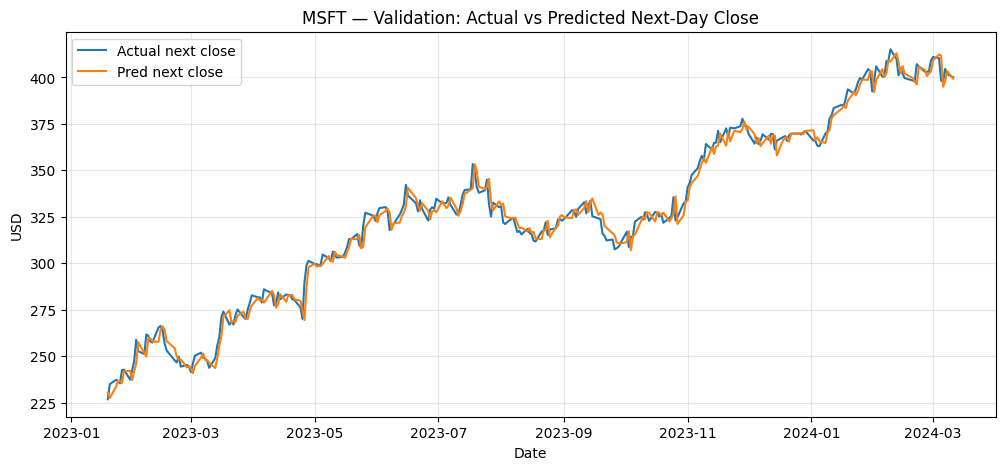

In [14]:
# Predict standardized returns on validation
y_pred_std = model.predict(X_val, verbose=0).ravel()
y_true_std = y_val.ravel()

# Back to log-returns
y_pred_log = scaler.inverse_transform(y_pred_std.reshape(-1,1)).ravel()
y_true_log = scaler.inverse_transform(y_true_std.reshape(-1,1)).ravel()

# Reconstruct next-day price: Ĉ_t = C_{t-1} * exp(r̂_t)
pred_next_close = lc_val * np.exp(y_pred_log)
true_next_close = lc_val * np.exp(y_true_log)

# Metrics
da   = (np.sign(pred_next_close - lc_val) == np.sign(true_next_close - lc_val)).mean()*100
mae  = mean_absolute_error(true_next_close, pred_next_close)
rmse = np.sqrt(mean_squared_error(true_next_close, pred_next_close))  # changed to manual RMSE
mape = (np.abs((true_next_close - pred_next_close)/np.maximum(1e-8, np.abs(true_next_close)))).mean()*100
r2   = r2_score(true_next_close, pred_next_close)

print(f"📊 Validation on {ticker} (price scale)")
print(f"  Directional Accuracy: {da:.2f}%")
print(f"  MAE:  {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAPE: {mape:.2f}%")
print(f"  R²:   {r2:.4f}")

# Quick overlay plot
val_dates = val_df.index[LOOKBACK:]
plt.figure(figsize=(12,5))
plt.plot(val_dates, true_next_close, label="Actual next close")
plt.plot(val_dates, pred_next_close, label="Pred next close")
plt.title(f"{ticker} — Validation: Actual vs Predicted Next-Day Close")
plt.xlabel("Date"); plt.ylabel("USD"); plt.grid(True, alpha=.3); plt.legend(); plt.show()


✅ Forecast ready:


,pred_logret,pred_close
date,,
2025-09-15,-0.000491,509.649531
2025-09-16,0.000249,509.776609
2025-09-17,0.000469,510.015633
2025-09-18,0.001641,510.853333
2025-09-19,0.001786,511.766383


,pred_logret,pred_close
date,,
2025-11-17,0.002114,540.763588
2025-11-18,0.001776,541.725063
2025-11-19,0.001820,542.712140
2025-11-20,0.001743,543.658721
2025-11-21,0.001441,544.442711


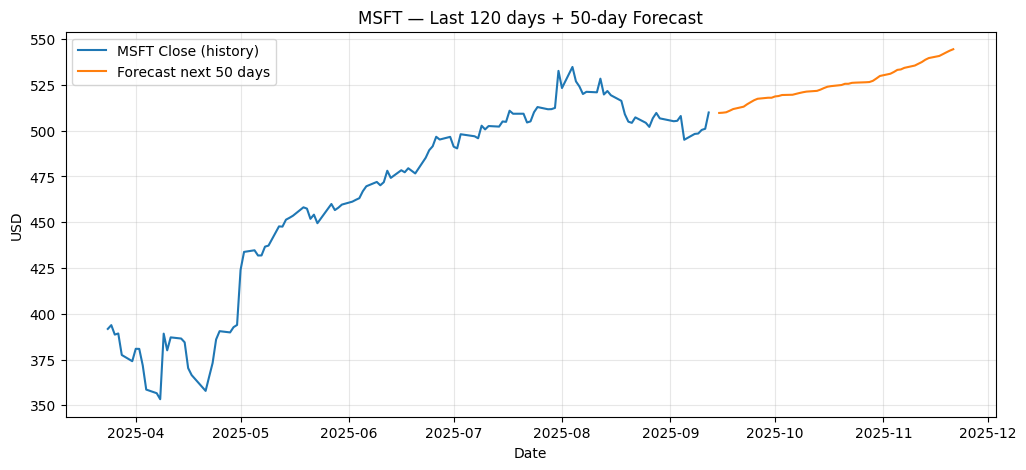

In [15]:
# Seed window = last LOOKBACK standardized returns from all (train+val+test) for stability
combined_std = pd.concat([train_sc["LogRet"], val_sc["LogRet"], test_sc["LogRet"]]).sort_index()
assert len(combined_std) >= LOOKBACK, "Not enough history to seed the window."

seed_window = combined_std.values[-LOOKBACK:].astype(np.float32).reshape(LOOKBACK, 1)
last_close  = float(close_df["Close"].iloc[-1])
last_date   = close_df.index.max()

forecast_df = recursive_forecast(
    model=model, scaler=scaler,
    seed_window=seed_window, last_close=last_close,
    n_days=N_FUTURE, last_history_date=last_date
)
print("✅ Forecast ready:")
display(forecast_df.head()); display(forecast_df.tail())

# Plot last ~120 bars + forecast
hist_days = 120
hist = close_df.tail(hist_days).copy()
plt.figure(figsize=(12,5))
plt.plot(hist.index, hist["Close"], label=f"{ticker} Close (history)")
plt.plot(forecast_df.index, forecast_df["pred_close"], label=f"Forecast next {N_FUTURE} days")
plt.title(f"{ticker} — Last {hist_days} days + {N_FUTURE}-day Forecast")
plt.xlabel("Date"); plt.ylabel("USD"); plt.grid(True, alpha=.3); plt.legend(); plt.show()


In [16]:
# Only if you plan to run multiple tickers in the same session
from tensorflow.keras import backend as K
K.clear_session()
del model
import gc; gc.collect()
print("🧹 Cleared session.")



🧹 Cleared session.
🧹 Cleared session.
